In [428]:
from __future__ import print_function, division
%matplotlib inline

# import used packages and modules
# import display function to display the table of the pandas dataframe
from IPython.display import display

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelSpreading

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.exceptions import NotFittedError

from scipy import signal

from hmmlearn import hmm
from seqlearn.hmm import MultinomialHMM

import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv


import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization

# Importing Data

In [429]:
train_manchester = pd.read_csv('../data/misc/Train_Manchester_Northwich.csv')
london_data = pd.read_csv('../data/london_data/london_data.csv')
train_data_mar = pd.read_csv('../data/validation/train-15-03-2018.csv')

data04 = pd.read_csv('../data/meadows_december/meadows-2017-12-04.csv')
data05 = pd.read_csv('../data/meadows_december/meadows-2017-12-05.csv')
data06 = pd.read_csv('../data/meadows_december/meadows-2017-12-06.csv')
data07 = pd.read_csv('../data/meadows_december/meadows-2017-12-07.csv')

bike_data_old = pd.read_csv('../data/misc/2015061911.csv')
bike_data_old2 = pd.read_csv('../data/misc/2015061817.csv')
bike_data_old3 = pd.read_csv('../data/misc/20150618.csv')
bike_data_feb = pd.read_csv('../data/misc/bike_feb.csv')

walk_data_vlad1 = pd.read_csv('../data/validation/015Outdoor-Day-2018-02-28.csv')
walk_data_vlad2 = pd.read_csv('../data/validation/024Outdoor-Day-2018-03-05.csv')

bus_data = pd.read_csv('../data/validation/queensferry-13-03-2018.csv')

# Merging Data

In [430]:
bin_vals = ['bin'+str(x) for x in range(0,16)]
norm_bin_vals = ['bin_norm'+str(x) for x in range(0,16)]
pm_vals = ['pm1', 'pm2_5', 'pm10']

In [439]:
# environment index is 0 as all data from these datasets is walking data
data04['environment_index'] = 0
data05['environment_index'] = 0
data06['environment_index'] = 0
data07['environment_index'] = 0

walk_data_vlad1['environment_index'] = 0
walk_data_vlad2['environment_index'] = 0

# environment index is 3 for bike data
bike_data_old['environment_index'] = 3
bike_data_old2['environment_index'] = 3
bike_data_old3['environment_index'] = 3
bike_data_feb['environment_index'] = 3

# rename columns
bike_data_old2 = bike_data_old2.rename(
    index=str, columns={"latitude":'gpsLatitude', "longitude":'gpsLongitude', 
                        'time': 'phoneTimestamp', 'accuracy': 'gpsAccuracy'})
bike_data_old3 = bike_data_old3.rename(
    index=str, columns={"latitude":'gpsLatitude', "longitude":'gpsLongitude', 
                        'time': 'phoneTimestamp', 'accuracy': 'gpsAccuracy'})

labels = bin_vals + pm_vals + ['environment_index', 
                               'gpsLatitude', 
                               'gpsLongitude', 
                               'humidity', 
                               'temperature',
                               'phoneTimestamp',
                              ]

bus_data_bus = bus_data[bus_data['environment_index']==4].copy()

train_data_mar['environment_index'] = 2

data = pd.concat([london_data[labels],
                  train_manchester[labels], 
                  data04[labels], 
                  data05[labels],
                  train_data_mar[700:][labels],
                  data06[labels],
                  data07[labels],
                  bus_data_bus[labels],
                  walk_data_vlad1[labels],
                  walk_data_vlad2[labels],
                  bike_data_old2[labels],
                  bike_data_feb[labels]], ignore_index=True)


### Remove outliers

In [440]:
# remove indoor labelled data for this set of experiments
data = data[data['environment_index']!=7]
data = data[data['environment_index']!=5]
data = data[data['humidity']>0]
data = data[data['temperature']>0]
data['total'] = data[bin_vals].apply(lambda row: np.sum(row), axis=1)
data = data[data['total']>0]
data = data[data['total']<12000]
data = data[data['temperature']<35]

### Data Information

In [441]:
display(data.describe())
data.to_csv('../data/training_data.csv')

,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin15,pm1,pm2_5,pm10,environment_index,gpsLatitude,gpsLongitude,humidity,temperature,total
count,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,...,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000
mean,427.300610,103.572749,59.989092,34.252542,12.852468,12.492882,7.844888,3.619523,2.809946,0.904419,...,0.238861,5.690336,10.224480,20.376333,2.053984,55.386725,-2.672723,52.878766,18.288882,667.051766
std,687.696491,193.483991,106.021429,55.967233,21.672430,21.796565,23.721709,48.235996,108.579134,8.832615,...,1.991819,8.044508,10.778896,47.069200,1.552355,1.220987,0.975373,10.687107,7.249168,1072.710005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.032004,0.032004,0.032004,0.000000,51.493892,-3.397216,17.600000,0.100000,1.000000
25%,61.000000,25.000000,16.000000,8.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.742531,4.851986,6.790932,0.000000,55.851607,-3.198313,44.700000,14.100000,162.000000
50%,279.000000,72.000000,40.000000,22.000000,7.000000,7.000000,4.000000,1.000000,0.000000,0.000000,...,0.000000,3.764446,7.887015,11.183998,2.000000,55.944530,-3.188331,52.700000,18.500000,486.000000
75%,509.000000,113.000000,71.000000,41.000000,16.000000,16.000000,10.000000,3.000000,1.000000,1.000000,...,0.000000,7.236877,12.253192,19.901491,3.000000,55.950935,-2.358013,57.509713,24.000000,765.000000
max,7317.000000,2169.000000,1276.000000,730.000000,293.000000,434.000000,656.000000,3343.000000,7955.000000,258.000000,...,58.000000,94.733292,127.625282,1051.750977,6.000000,56.008247,-0.100202,89.800000,34.200001,11557.000000


### Labels

In [425]:
labels_idx = np.array([0, 1, 2, 3, 4, 6])

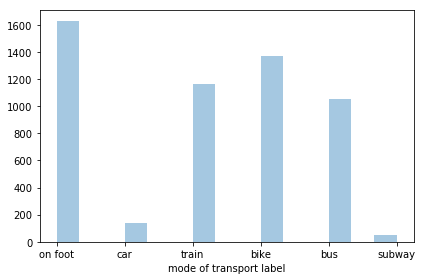

In [205]:
hist = plt.figure()
# data['environment_index'] = np.where(data['environment_index']==6, 5, data['environment_index'])
g = sns.distplot(data['environment_index'], kde=False)
g.set_xticklabels(['', 'on foot', 'car', 'train', 'bike', 'bus', 'subway'])
plt.xlabel('mode of transport label')
plt.tight_layout()
hist.savefig('../report/distribution.pdf')
plt.show()

# Kmeans

In [9]:
# method to get the cluster means of the data points based on coordinates
# and the queried columns
def get_location_cluster_means(data, cluster_no, cols):
    # obtain indices of clusters
    kmeans = KMeans(n_clusters=cluster_no, random_state=0)
    # remove data rows with null coordinates
    data = data[~np.isnan(data['gpsLatitude'])]
    # get the indices of the location based clusters
    indices = kmeans.fit_predict(data[['gpsLatitude', 'gpsLongitude']])
    freqs = np.bincount(indices)
    # initialise means of queried columns
    means = np.zeros((cluster_no, len(cols)))
    # assign clustered_indices to dataframe
    data['clustered_index'] = indices
    # compute means of queried columns
    for index in np.unique(indices):
        means[index] = np.mean(data[data['clustered_index'] == index][cols])
    return means, data

In [10]:
# method to get the clusters of the environments corresponding to the 6 environments based on
# the queried columns and number of location clusters
def get_environment_clusters(data, cluster_no, cols, kmeans=None):
    means, d = get_location_cluster_means(data, cluster_no, cols)
    # we have 5 clusters corresponding to 5 different types of environment
    if not kmeans:
        environment_kmeans = KMeans(n_clusters=5, random_state=0)
        environment_indices = environment_kmeans.fit_predict(means)
    else:
        try:
            environment_kmeans = kmeans
            environment_indices = environment_kmeans.predict(means)
        except NotFittedError:
            environment_indices = environment_kmeans.fit_predict(means)
    # predict the cluster indices
    # sort the indices based on the means of the clusters
    idx = np.argsort(environment_kmeans.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(5)
    # append the indices to the dataframe
    d['unsupervised_environment_index'] = lut[environment_indices][d['clustered_index']]
    return d

# Stats Methods

In [474]:
def plot_confusion_matrix(labels, predictions, title='Confusion matrix',
                          file='../report/confusion_matrix.pdf',
                          classes=['on foot', 'car', 'train', 'bike', 'bus', 'subway'],
                          classes2=['on foot', 'car', 'train', 'bike', 'bus', 'subway'],
                          reshape=False):
    """Plots a confusion matrix."""
    cmatrix = np.array(confusion_matrix(labels, predictions))
    # normalize confusion matrix
    cm = cmatrix/cmatrix.sum(axis=1)[:, np.newaxis]
    if reshape:
        cm = cm[~np.isnan(cm)].reshape((4,6))
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes2, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True data')
    plt.xlabel('Predicted data')
    plt.tight_layout()
    plt.savefig(file)
    plt.show()

In [196]:
def get_training_accuracy_with_kfolds_iloc(estimator, x_tr, y_tr, kf):
    score_array = np.empty(kf.n_folds)
    
    for (idx, (train_feature, test_feature)) in enumerate(kf):
        estimator.fit(x_tr.iloc[train_feature], y_tr.iloc[train_feature])
        y_pred = estimator.predict(x_tr.iloc[test_feature])
        cm = confusion_matrix(y_tr.iloc[test_feature], y_pred)
        cm_norm = cm.astype('float')/cm.sum(axis=1)
        score_array[idx] = accuracy_score(y_tr.iloc[test_feature], y_pred, normalize=True)
#         for plotting a confusion matrix uncomment the line below
#         plot_confusion_matrix(y_tr.iloc[test_feature], y_pred)
        
    return np.mean(score_array)

In [464]:
def get_training_accuracy_mixed_models(estimator, attributes_list, x_tr, y_tr, x_ts, y_ts, title='Confusion Matrix', file='../report/confusion_matrix.pdf', 
                                       classes=['on foot', 'car', 'train', 'bike', 'bus', 'subway'], 
                                       classes2=['on foot', 'car', 'train', 'bike', 'bus', 'subway']):
    
    probs_array = np.empty((len(attributes_list), x_ts.shape[0], 6))

    for estimator_idx, attrs in enumerate(attributes_list):
        estimator.fit(x_tr[attrs], y_tr)
        probs_array[estimator_idx] = estimator.predict_proba(x_ts[attrs])

    final_labels = labels_idx[np.argmax(np.mean(probs_array, axis=0), axis=1)]
    score = accuracy_score(y_ts, final_labels, normalize=True)
#     for plotting a confusion matrix uncomment the line below
#     plot_confusion_matrix(y_ts, final_labels, title=title, file=file, classes=classes, classes2=classes2)
    
    return score, final_labels

In [442]:
def get_training_accuracy_mixed_models_kfolds(estimator, attributes, x_tr, y_tr, kf):
    score_array = np.empty(kf.n_folds)
    
    for (idx, (train_feature, test_feature)) in enumerate(kf):
        
        score_array[idx], _ = get_training_accuracy_mixed_models(
            estimator, attributes, x_tr.iloc[train_feature], y_tr.iloc[train_feature],
            x_tr.iloc[test_feature], y_tr.iloc[test_feature]
        )
                        
    return np.mean(score_array)

# Absolute Values

### Bin Values

In [15]:
svc = SVC()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.554259679457475


In [16]:
rf = RandomForestClassifier(random_state=0)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.8737288845646788


In [17]:
et = ExtraTreesClassifier(n_jobs=-1, random_state=0)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(et, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.8678123733586858


In [18]:
lr = LogisticRegressionCV(n_jobs=-1)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(lr, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.7879458842962206


In [19]:
knn = KNeighborsClassifier(n_neighbors=5)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.8456274654979901


In [20]:
clf = MLPClassifier()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, data[bin_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.7811090914997922


### First 3 Bin Counts

In [21]:
svc = SVC()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, data[bin_vals[:3]], 
                                                          data['environment_index'], kf))

Accuracy: 0.548343852221449


In [22]:
rf = RandomForestClassifier(random_state=0)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, data[bin_vals[:3]], 
                                                          data['environment_index'], kf))

Accuracy: 0.7975625020305359


In [23]:
lr = LogisticRegressionCV()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(lr, data[bin_vals[:3]], 
                                                          data['environment_index'], kf))

Accuracy: 0.6801641869905491


In [24]:
knn = KNeighborsClassifier(n_neighbors=5)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, data[bin_vals[:3]], 
                                                          data['environment_index'], kf))

Accuracy: 0.7947881488523839


In [25]:
clf = MLPClassifier()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, data[bin_vals[:3]], 
                                                          data['environment_index'], kf))

Accuracy: 0.6925440433910547


### PM Values

In [26]:
svc = SVC()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, data[pm_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.7668708886992772


In [27]:
rf = RandomForestClassifier(random_state=0)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, data[pm_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.7890534026650889


In [28]:
knn = KNeighborsClassifier(n_neighbors=5)
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, data[pm_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.7672421133988007


In [29]:
lr = LogisticRegressionCV()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(lr, data[pm_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.665371626531879


In [30]:
clf = MLPClassifier()
kf = KFold(len(data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, data[pm_vals], 
                                                          data['environment_index'], kf))

Accuracy: 0.733964751607757


### Urban Environments

In [31]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

rf = RandomForestClassifier(random_state=0, n_jobs=-1)
kf = KFold(len(clustered_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, clustered_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_data['environment_index'], kf))

Accuracy: 0.9127375726931831


In [32]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

svc = SVC()
kf = KFold(len(clustered_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, clustered_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_data['environment_index'], kf))

Accuracy: 0.5561082792854566


In [33]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

lr = LogisticRegressionCV(n_jobs=-1)
kf = KFold(len(clustered_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(lr, clustered_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_data['environment_index'], kf))

Accuracy: 0.8043989528419807


In [34]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

knn = KNeighborsClassifier()
kf = KFold(len(clustered_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, clustered_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_data['environment_index'], kf))

Accuracy: 0.8456274654979901


In [35]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clf = MLPClassifier()
kf = KFold(len(clustered_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_data['environment_index'], kf))

Accuracy: 0.7805593506389135


### Normalised Bin Counts

In [36]:
data_normalised = data[data['total']>0].copy().reindex()
data_normalised[bin_vals] = data_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)
data_normalised['pca_pm'] = PCA(n_components=1).fit_transform(data_normalised[pm_vals])

In [37]:
rf = RandomForestClassifier(random_state=0)
kf = KFold(len(data_normalised), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, data_normalised[bin_vals+['total']], 
                                                          data_normalised['environment_index'], kf))

Accuracy: 0.8777971379276736


In [38]:
svc = SVC()
kf = KFold(len(data_normalised), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(svc, data_normalised[bin_vals+['total']], 
                                                          data_normalised['environment_index'], kf))

Accuracy: 0.6694407348573324


In [39]:
knn = KNeighborsClassifier(n_neighbors=5)
kf = KFold(len(data_normalised), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, data_normalised[bin_vals], 
                                                          data_normalised['environment_index'], kf))

Accuracy: 0.7592895945939013


In [40]:
clf = MLPClassifier()
kf = KFold(len(data_normalised), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, data_normalised[bin_vals], 
                                                          data_normalised['environment_index'], kf))

/Users/mihaivisuian/miniconda3/envs/hons/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 0.7315611101516533


In [41]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['total']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

rf = RandomForestClassifier(random_state=0, n_estimators=300, n_jobs=-1)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, clustered_normalised_data[['unsupervised_environment_index', 'total']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

print("Feature Importance:", rf.feature_importances_)

Accuracy: 0.9278962280766251
Feature Importance: [0.16336806 0.28964697 0.07470702 0.03641311 0.04627727 0.0637022
 0.03849111 0.07190529 0.07885148 0.06338382 0.03056109 0.01342983
 0.00737408 0.00589793 0.00456066 0.00412529 0.00296651 0.00433828]


# Best Models

## Add temperature and humidity

In [42]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['total']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

rf = RandomForestClassifier(random_state=0, n_estimators=300, n_jobs=-1)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, clustered_normalised_data[['unsupervised_environment_index', 'temperature', 'humidity', 'total']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

print("Feature Importance:", rf.feature_importances_)

Accuracy: 0.9669069681150301
Feature Importance: [0.1078841  0.1763229  0.09647689 0.22388164 0.0570099  0.0215426
 0.03049709 0.05170886 0.03086362 0.04949584 0.0554646  0.04911703
 0.02214478 0.00944902 0.00424871 0.00378614 0.00282034 0.00280128
 0.0018058  0.00267885]


### Neural Network

In [43]:
# environment clustering on raw bin values: 3 hidden layers
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['total']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5, 
                    hidden_layer_sizes=(20,), 
                    random_state=1, 
                    max_iter=500)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.7542990077305706


### KNN

In [426]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['total']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.8023655101304502


### Mixed Model

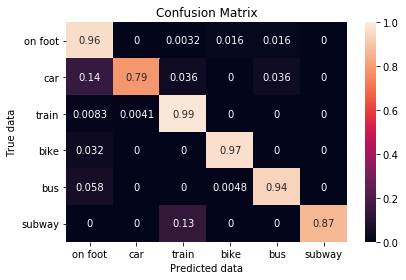

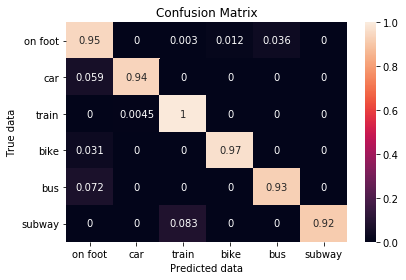

KeyboardInterrupt: 

In [443]:
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

get_training_accuracy_mixed_models_kfolds(rf, 
                                          [
                                              ['unsupervised_environment_index', 'total']+bin_vals[:8],
                                              ['humidity', 'temperature']+bin_vals[8:],
                                          ], 
                                          clustered_normalised_data,
                                          clustered_normalised_data['environment_index'], kf)

### Validating Models

#### Train Data

In [405]:
kmeans = KMeans(n_clusters=5, random_state=0)
clustered_train = get_environment_clusters(data, 40, bin_vals, kmeans).reindex()
clustered_normalised_train = clustered_train[clustered_train['total']>0].copy().reindex()
clustered_normalised_train[bin_vals] = clustered_normalised_train[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

#### Bike validation data

In [47]:
bike_data_validation = pd.read_csv('../data/misc/2015071111.csv')
bike_data_validation['environment_index'] = 3
bike_data_validation['total'] = bike_data_validation[bin_vals].apply(lambda row: np.sum(row), axis=1)

bike_data_validation = bike_data_validation.rename(index=str, 
                                                   columns={
                                                       "latitude":'gpsLatitude', 
                                                       "longitude":'gpsLongitude',
                                                       "time": 'phoneTimestamp',
                                                   })
display(bike_data_validation.describe())


,Unnamed: 0,phoneTimestamp,gpsLatitude,gpsLongitude,bin0,bin1,bin2,bin3,bin4,bin5,...,temperature,humidity,alphaVersion,urban_space,o3_ae,o3_we,no2_ae,no2_we,environment_index,total
count,1278.000000,1.278000e+03,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,...,1278.000000,1278.000000,1278.0,1278.000000,1278.000000,1278.000000,1278.000000,1278.00000,1278.0,1278.000000
mean,638.500000,2.015071e+13,43.021981,-2.691790,4.439750,0.847418,0.647887,0.450704,0.308294,0.489828,...,24.307660,46.477844,2.0,-0.226917,-5338.194053,-4898.507042,-2190.475743,-4643.70892,3.0,7.766041
std,369.071131,5.951445e+02,23.859431,0.916951,3.258248,1.010999,0.799152,0.723471,0.558645,0.687378,...,0.675096,3.016924,0.0,0.419002,28382.447290,28619.176291,28440.371627,28624.02541,0.0,4.354769
min,0.000000,2.015071e+13,-1.000000,-3.203310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,22.860000,42.249895,2.0,-1.000000,-32734.000000,-32734.000000,-32734.000000,-32734.00000,3.0,0.000000
25%,319.250000,2.015071e+13,55.939598,-3.189197,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,23.810000,44.136598,2.0,0.000000,-30686.000000,-30430.000000,-30942.000000,-30686.00000,3.0,5.000000
50%,638.500000,2.015071e+13,55.942342,-3.184279,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,23.910000,46.206020,2.0,0.000000,-27870.000000,-27230.000000,-21214.000000,-27358.00000,3.0,7.000000
75%,957.750000,2.015071e+13,55.945479,-3.180138,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,24.980000,47.396442,2.0,0.000000,26402.000000,27170.000000,25634.000000,26658.00000,3.0,10.000000
max,1277.000000,2.015071e+13,55.946662,-1.000000,70.000000,9.000000,5.000000,5.000000,4.000000,3.000000,...,25.530000,56.606663,2.0,0.000000,32546.000000,32546.000000,32546.000000,32546.00000,3.0,82.000000


In [48]:
clustered_validation_data = get_environment_clusters(bike_data_validation, 40, bin_vals, kmeans)

clustered_normalised = clustered_validation_data[clustered_validation_data['total']>0].copy().reindex()
clustered_normalised[bin_vals] = clustered_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

print(get_training_accuracy_mixed_models(rf, [
    bin_vals[:8]+['total','unsupervised_environment_index'], bin_vals[8:]+['temperature', 'humidity']],
                                         clustered_normalised_train, clustered_normalised_train['environment_index'],
                                         clustered_normalised, clustered_normalised['environment_index'],
                                        ))

# rf.fit(clustered_normalised_train[bin_vals+['unsupervised_environment_index', 'total']], 
#        clustered_normalised_train['environment_index'])

# predictions = rf.predict(clustered_normalised[bin_vals+['unsupervised_environment_index', 'total']])

# print("Validation accuracy:", accuracy_score(clustered_normalised['environment_index'], predictions))
 

0.9184481393507522


In [49]:
clustered_validation_data = get_environment_clusters(bike_data_validation, 40, bin_vals, kmeans)

print(get_training_accuracy_mixed_models(rf, [
    bin_vals[:8]+['total','unsupervised_environment_index'], bin_vals[8:]+['temperature', 'humidity']],
                                         clustered_train, clustered_train['environment_index'],
                                         clustered_validation_data, clustered_validation_data['environment_index'],
                                        ))

# rf.fit(clustered_train[bin_vals + ['unsupervised_environment_index', 'total']], 
#        clustered_train['environment_index'])

# predictions = rf.predict(clustered_validation_data[bin_vals + ['unsupervised_environment_index', 'total']])

# print("Validation accuracy:", accuracy_score(clustered_validation_data['environment_index'], predictions))
 

0.9162754303599374


### Walking Validation Data

In [50]:

walk_data_validation_total = pd.read_csv('../data/validation/016Outdoor-Night-2018-02-28.csv')

walk_data_validation_total['environment_index'] = 0
walk_data_validation_total = walk_data_validation_total[walk_data_validation_total['total']>0]

display(walk_data_validation_total.describe())

,Unnamed: 0,phoneTimestamp,pm1,pm2_5,pm10,temperature,humidity,bin0,bin1,bin2,...,bin14,bin15,total,gpsLongitude,gpsLatitude,gpsAltitude,gpsAccuracy,luxLevel,motion,environment_index
count,640.000000,6.400000e+02,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,...,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.0
mean,320.500000,1.519852e+12,5.162149,12.112384,48.238336,0.318438,88.245157,130.696875,48.362500,36.084375,...,0.014063,0.042188,333.607813,-3.187060,55.855857,90.441880,250.504753,0.473438,2485.190625,0.0
std,184.896367,1.485294e+06,5.171345,46.269151,459.874463,1.318333,14.761573,203.997036,46.587591,31.910120,...,0.117841,0.230197,773.274792,0.126348,2.211353,73.529042,389.355498,1.182520,941.571760,0.0
min,1.000000,1.519849e+12,2.547426,3.906771,4.740481,0.000000,0.000000,49.000000,15.000000,14.000000,...,0.000000,0.000000,125.000000,-3.203796,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,160.750000,1.519850e+12,3.834170,6.560691,9.203300,0.000000,89.000000,90.000000,35.000000,26.000000,...,0.000000,0.000000,210.000000,-3.195649,55.941324,0.000000,10.000000,0.000000,2244.500000,0.0
50%,320.500000,1.519852e+12,4.343511,7.352633,12.131214,0.000000,93.400000,107.000000,42.000000,31.000000,...,0.000000,0.000000,238.000000,-3.191526,55.943939,141.100006,13.740500,0.000000,2714.500000,0.0
75%,480.250000,1.519853e+12,4.900614,8.421762,21.115125,0.000000,94.700005,125.000000,48.000000,37.000000,...,0.000000,0.000000,271.000000,-3.185774,55.945097,152.759762,800.000000,1.000000,3096.500000,0.0
max,640.000000,1.519854e+12,87.943596,936.273600,11054.397000,8.900001,100.600000,4610.000000,897.000000,483.000000,...,1.000000,2.000000,14644.000000,0.000000,55.948084,180.875992,1000.000000,17.000000,4159.000000,0.0


In [51]:
clustered_validation_data = get_environment_clusters(walk_data_validation_total, 40, bin_vals, kmeans)

clustered_normalised = clustered_validation_data[clustered_validation_data['total']>0].copy().reindex()
clustered_normalised[bin_vals] = clustered_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

# rf.fit(clustered_normalised_train[bin_vals+['unsupervised_environment_index', 'temperature', 'humidity', 'total']], 
#        clustered_normalised_train['environment_index'])

# predictions = rf.predict(clustered_normalised[bin_vals+['unsupervised_environment_index', 'temperature', 'humidity', 'total']])
print(get_training_accuracy_mixed_models(rf, [
    bin_vals[:8]+['total','unsupervised_environment_index'], bin_vals[8:]+['temperature', 'humidity'],],
                                         clustered_normalised_train, clustered_normalised_train['environment_index'],
                                         clustered_normalised, clustered_normalised['environment_index'],
                                        ))


0.9375


In [52]:
clustered_validation_data = get_environment_clusters(walk_data_validation_total, 40, bin_vals, kmeans)

print(get_training_accuracy_mixed_models(rf, [
    bin_vals[:8]+['total','unsupervised_environment_index'], bin_vals[8:]+['temperature', 'humidity']],
                                         clustered_train, clustered_train['environment_index'],
                                         clustered_validation_data, clustered_validation_data['environment_index'],
                                        ))
 

0.9328125


### Bus Validation Data

In [313]:
bus_data_val = pd.read_csv('../data/validation/queensferry-13-03-2018.csv')
bus_data_val = bus_data_val[bus_data_val['environment_index']!=7]
display(bus_data_val[bus_data_val['environment_index']==0].describe())

,phoneTimestamp,pm1,pm2_5,pm10,temperature,humidity,bin0,bin1,bin2,bin3,...,bin14,bin15,total,gpsLongitude,gpsLatitude,gpsAltitude,gpsAccuracy,luxLevel,motion,environment_index
count,3.860000e+02,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,...,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.0
mean,1.520963e+12,7.335591,9.850443,15.465898,10.376943,61.771503,349.601036,85.370466,47.445596,25.795337,...,0.002591,0.010363,534.764249,-3.304039,55.972971,98.415633,10.019334,25.031088,3154.585492,0.0
std,2.985736e+06,10.072208,15.866564,18.251328,2.885479,9.230014,253.840192,143.090962,144.566646,108.812920,...,0.050899,0.101400,645.435094,0.103268,0.019217,34.579676,0.170743,40.428858,2115.006339,0.0
min,1.520957e+12,3.059967,4.004622,4.502368,7.600000,34.200000,121.000000,25.000000,10.000000,5.000000,...,0.000000,0.000000,225.000000,-3.398579,55.945204,52.635492,10.000000,0.000000,0.000000,0.0
25%,1.520962e+12,4.807848,6.475814,9.079873,8.600000,55.750001,238.000000,54.000000,27.000000,14.000000,...,0.000000,0.000000,360.000000,-3.397681,55.953397,67.818725,10.000000,0.000000,701.500000,0.0
50%,1.520963e+12,5.977924,8.068533,12.461347,9.200000,65.600000,284.500000,67.000000,34.000000,18.000000,...,0.000000,0.000000,430.500000,-3.396614,55.989291,79.919386,10.000000,9.000000,3628.500000,0.0
75%,1.520967e+12,7.529586,9.960748,18.579217,11.175000,67.900000,365.000000,86.000000,45.000000,23.000000,...,0.000000,0.000000,548.750000,-3.191684,55.990040,131.414493,10.000000,28.000000,4964.000000,0.0
max,1.520967e+12,188.656660,306.175870,330.898830,21.000000,73.500000,3148.000000,2697.000000,2842.000000,2148.000000,...,1.000000,1.000000,11854.000000,-3.184060,55.992005,152.697968,12.000000,310.000000,6781.000000,0.0


In [314]:
clustered_validation_data = get_environment_clusters(bus_data_val, 40, bin_vals, kmeans)
clustered_normalised = clustered_validation_data[clustered_validation_data['total']>0].copy().reindex()
clustered_normalised[bin_vals] = clustered_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

print(get_training_accuracy_mixed_models(rf, [
    bin_vals[:8]+['total','unsupervised_environment_index'], ['temperature', 'humidity']+bin_vals[8:]],
                                         clustered_normalised_train, clustered_normalised_train['environment_index'],
                                         clustered_normalised, clustered_normalised['environment_index'],
                                        ))



0.5912897822445561


In [315]:
clustered_validation_data = get_environment_clusters(bus_data, 40, bin_vals, kmeans)

print(get_training_accuracy_mixed_models(rf, [
    ['temperature', 'humidity']+bin_vals[8:],
    bin_vals[:8]+['total','unsupervised_environment_index']
],
                                         clustered_train, clustered_train['environment_index'],
                                         clustered_validation_data, clustered_validation_data['environment_index'],
                                        ))



0.6513698630136986


## Train data

In [56]:
train_data_validation = train_data_mar.loc[:600].copy()

In [57]:
clustered_validation_data = get_environment_clusters(train_data_validation, 40, bin_vals, kmeans)
clustered_normalised = clustered_validation_data[clustered_validation_data['total']>0].copy().reindex()
clustered_normalised[bin_vals] = clustered_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

print(get_training_accuracy_mixed_models(rf, [
    bin_vals[8:]+['temperature','humidity'],
    bin_vals[:8]+['total','unsupervised_environment_index']],
                                         clustered_normalised_train, clustered_normalised_train['environment_index'],
                                         clustered_normalised, clustered_normalised['environment_index'],
                                        ))


0.9384359400998337


In [58]:
clustered_validation_data = get_environment_clusters(train_data_validation, 40, bin_vals, kmeans)

print(get_training_accuracy_mixed_models(rf, [
    bin_vals[8:]+['temperature','humidity'], 
    bin_vals[:8]+['total','unsupervised_environment_index']
],
                                         clustered_train, clustered_train['environment_index'],
                                         clustered_validation_data, clustered_validation_data['environment_index'],
                                        ))




0.9434276206322796


## London

,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin15,pm1,pm2_5,pm10,environment_index,gpsLatitude,gpsLongitude,humidity,temperature,total
count,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,...,4485.000000,4485.000000,4.485000e+03,4.485000e+03,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000
mean,399.745819,90.612040,50.346265,27.546711,10.014716,9.554069,5.638127,2.868450,2.799777,0.719509,...,0.166109,5.451671,1.006204e+01,-2.573724e+28,1.757637,55.388811,-2.573460,52.160434,17.961485,600.925084
std,606.238681,166.437106,90.654975,48.370922,19.096830,20.380535,23.171334,52.418031,119.159570,8.773861,...,1.651186,7.216189,9.651039e+00,1.723626e+30,1.290149,0.976763,0.912422,11.746824,7.676528,934.010034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.032004,4.924610e-37,-1.154315e+32,0.000000,51.530733,-3.258313,17.600000,0.100000,1.000000
25%,20.000000,8.000000,6.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.541067,4.630844e+00,6.665748e+00,0.000000,54.837119,-3.191513,41.500000,13.100000,40.000000
50%,189.000000,63.000000,32.000000,15.000000,4.000000,4.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,2.927393,7.927042e+00,1.022565e+01,2.000000,55.942337,-3.184612,52.904504,17.770000,428.000000
75%,561.000000,103.000000,59.000000,29.000000,11.000000,11.000000,6.000000,2.000000,1.000000,0.000000,...,0.000000,7.565504,1.214149e+01,1.851962e+01,3.000000,55.945225,-1.581183,57.758359,24.500000,739.000000
max,7173.000000,2169.000000,1276.000000,730.000000,293.000000,434.000000,656.000000,3343.000000,7955.000000,258.000000,...,37.000000,94.733292,1.276253e+02,1.051751e+03,6.000000,55.960242,-0.104572,89.800000,30.500000,11557.000000


,pm1,pm2_5,pm10,bin0,bin1,bin2,bin3,bin4,bin5,bin6,...,bin12,bin13,bin14,bin15,temperature,humidity,gpsLatitude,gpsLongitude,environment_index,total
count,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,...,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000
mean,9.134637,11.635371,20.494373,989.440072,218.245081,113.971377,59.087657,18.336315,13.837209,7.468694,...,0.409660,0.384615,0.279070,0.597496,24.720394,49.430054,54.975734,-1.956286,1.896243,1428.987478
std,14.642695,19.191411,54.518888,1203.383356,351.027905,193.066026,100.549892,38.038388,31.865313,29.798583,...,2.236544,1.995653,1.400502,3.059282,4.474313,4.948827,1.322520,0.920877,1.369131,1898.490384
min,0.411910,0.653727,0.660724,46.000000,16.000000,9.000000,8.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,17.000000,37.600002,51.493892,-3.258045,0.000000,146.000000
25%,3.859115,4.727633,6.068021,425.500000,89.000000,47.000000,22.500000,4.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,23.450000,46.500000,54.594099,-2.884902,2.000000,628.000000
50%,5.543733,6.676572,9.249994,659.000000,125.000000,63.000000,32.000000,7.000000,5.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,25.300001,48.100002,55.404505,-1.663305,2.000000,894.000000
75%,8.226254,10.365916,14.109243,1109.000000,197.000000,90.500000,45.500000,13.000000,11.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,26.700001,53.100002,55.951940,-1.546496,2.000000,1477.500000
max,87.465172,117.258400,1051.750977,7317.000000,2044.000000,1170.000000,608.000000,240.000000,434.000000,656.000000,...,34.000000,29.000000,15.000000,37.000000,72.500000,61.000000,56.008247,-0.100202,6.000000,11417.000000


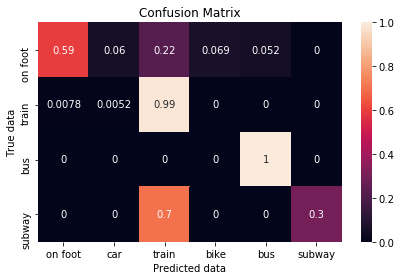

0.8694096601073346


In [448]:
ldn = pd.concat([london_data[500:860], london_data[1850:]])
ldn_val = pd.concat([london_data[:500], london_data[860:920]], ignore_index=True)
ldn_val = ldn_val[ldn_val['environment_index']!=7]
ldn_val['total'] = ldn_val[bin_vals].apply(lambda row: np.sum(row), axis=1)
ldn_val = ldn_val[ldn_val['total']>0]
ldn_val = ldn_val[ldn_val['total']<12000]

ldn['total'] = ldn[bin_vals].apply(lambda row: np.sum(row), axis=1)

data2 = pd.concat([ldn[labels],
                  train_manchester[labels], 
                  data04[labels], 
                  data05[labels],
                  train_data_mar[labels],
                  data06[labels],
                  data07[labels],
#                   bus_data_bus[labels],
                  walk_data_vlad1[labels],
                  walk_data_vlad2[labels],
                  bike_data_old2[labels],
                  bike_data_feb[labels]], ignore_index=True)

# remove indoor labelled data for this set of experiments
data2 = data2[data2['environment_index']!=7]
data2 = data2[data2['environment_index']!=5]
data2 = data2[data2['humidity']>0]
data2 = data2[data2['temperature']>0]
data2['total'] = data2[bin_vals].apply(lambda row: np.sum(row), axis=1)
data2 = data2[data2['total']>0]
data2 = data2[data2['total']<12000]
data2 = data2[data2['temperature']<35]

data2.to_csv('../data/training_data2.csv')

display(data2.describe())

ldn_val.to_csv('../data/validation/london_autumn_trans.csv')

display(ldn_val.describe())

kmeans = KMeans(n_clusters=5, random_state=0)
clustered_train = get_environment_clusters(data2, 40, bin_vals, kmeans).reindex()
clustered_normalised_train = clustered_train[clustered_train['total']>0].copy().reindex()
clustered_normalised_train[bin_vals] = clustered_normalised_train[bin_vals].apply(lambda row: row/np.sum(row), axis=1)


clustered_validation_data = get_environment_clusters(ldn_val, 40, bin_vals, kmeans)
clustered_normalised = clustered_validation_data[clustered_validation_data['total']>0].copy().reindex()
clustered_normalised[bin_vals] = clustered_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

score, pred_labels = get_training_accuracy_mixed_models(rf, [
    bin_vals[8:]+['temperature','humidity'],
    bin_vals[:8]+['total','unsupervised_environment_index']],
                                         clustered_normalised_train, clustered_normalised_train['environment_index'],
                                         clustered_normalised, clustered_normalised['environment_index'],
                                         title='Confusion Matrix',
                                         classes2=['on foot', 'train', 'bus', 'subway'],
                                         file='../report/val_london_conf.pdf',
                                        )
print(score)


## Adding Speed

In [449]:
from math import radians, sqrt, cos, sin, atan2

def distance_of_coords(lat1, lon1, lat2, lon2):
    # If one coordinate is 0, return 0
    if (lat1 == 0. and lon1 == 0.) or (lat2 == 0. and lon2 == 0.):
        return 0.
    
    # approximate radius of earth in km
    R = 6373.0

    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    dlon = abs(lon2_rad - lon1_rad)
    dlat = abs(lat2_rad - lat1_rad)
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    
    if a < 0:
        return 0
    
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

0.9320214669051878


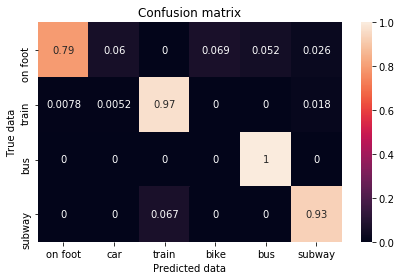

In [473]:
coords_train = list(zip(ldn_val['gpsLatitude'], ldn_val['gpsLongitude']))
coords_train.append(( ldn_val['gpsLatitude'].iloc[-1], ldn_val['gpsLongitude'].iloc[-1]))
adj_coords_train = list(zip(coords_train[:-1], coords_train[1:]))
distances = np.asarray(list(map(lambda c: distance_of_coords(c[0][0], c[0][1], c[1][0], c[1][1]), adj_coords_train)))
ldn_val['distances'] = distances
for idx, label in enumerate(pred_labels):
    if ldn_val['distances'].iloc[idx] == 0.0 and pred_labels[idx] == 2:
        pred_labels[idx] = 6
    if ldn_val['distances'].iloc[idx] <= 0.2 and pred_labels[idx] == 2 and ldn_val['environment_index'].iloc[idx] == 0:
        pred_labels[idx] = 0
print(accuracy_score(pred_labels, ldn_val['environment_index']))

plot_confusion_matrix(ldn_val['environment_index'], pred_labels, title='Confusion matrix',
                          file='../report/val_london_conf_speed.pdf',
                          classes=['on foot', 'car', 'train', 'bike', 'bus', 'subway'],
                          classes2=['on foot', 'train', 'bus', 'subway'])